# Main notebook for simulation experiments

## Imports

In [16]:
import numpy as np
# import pandas as pd
import matplotlib.pyplot as plt
import coclusterSVD as ccSVD
import bicluster as bc
import submatrix as sm
import importlib 
import multiprocessing

np.set_printoptions(precision=3, suppress=True, linewidth=100)

def generate(seed, num_bicluster, M, N, m, n):
    '''
    Generate a matrix with biclusters
    '''

    A = np.zeros((M, N))

    # check: len(num_bicluster) == len(m) == len(n)
    assert num_bicluster == len(m) == len(n)
    
    # insert biclusters into A disjointly
    startx = starty = 0
    for i in range(num_bicluster):
        A[startx:startx+m[i], starty:starty+n[i]] = i+1
        startx += m[i]
        starty += n[i]

    # permutation of M and N
    permx = np.random.RandomState(seed).permutation(M)
    permy = np.random.RandomState(seed+1).permutation(N)

    # print permx and permy
    # print('permx: ', permx)
    # print('permy: ', permy)

    # permute A
    B = A[permx, :]
    B = B[:, permy]

    return B, permx, permy, A


## Generate Big Matrix ($M \times N$)

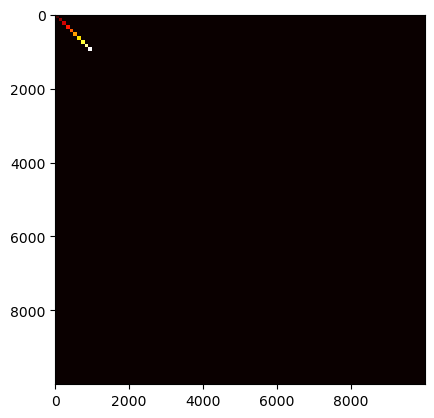

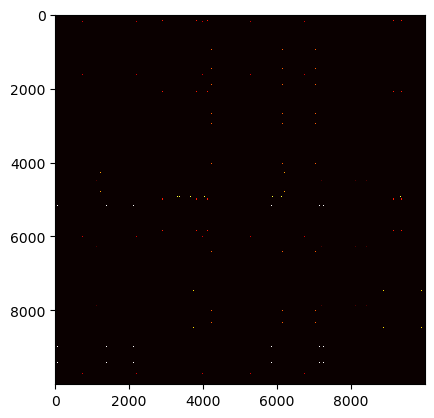

In [18]:
seed = 42
K = 10 # number of biclusters

# random n(0) n(1) n(2) ... n(K-1) as the length of each bicluster base vector
# n = np.random.RandomState(seed=seed).randint(
# num_pool/5, num_pool, K)
# m is the height of biclusters
# m = np.random.RandomState(
# seed=seed+1).randint(num_pool/5, num_pool, K)
phi = 100
psi = 100

m = np.ones(K, dtype=int) * phi
n = np.ones(K, dtype=int) * psi

M = 10000
N = 10000

B, permx, permy, A = generate(
        seed=seed, num_bicluster=K, M=M, N=N, m=m, n=n
    )

# print('permx: ', permx)
# print('permy: ', permy)

plt.imshow(A, cmap='hot', interpolation='nearest')
plt.show()

plt.imshow(B, cmap='hot', interpolation='nearest')
plt.show()


## Generate submatrix list (and labelMatList)

In [21]:
importlib.reload(ccSVD)

def find_bicluster_count(A, Tp, Tm, Tn, sizex, sizey, num_iter=100):
    count = 0
    result = []
    for i in range(num_iter):
        ite = ccSVD.isBiclusterFoundConst(A, Tp, Tm, Tn, sizex, sizey, 10)
        result.append(ite)
        if ite < 300:
            count += 1
    return count/num_iter, result

partition : int = 10

Tp_list = ccSVD.Tp(range(100, 250 ,20), phi=50, Tm=4, M=10000)
print('Tp_list', Tp_list)


Tp_list [50 14  5  2  1  1  1  1]


In [17]:

sizex = M // partition # block size
sizey = N // partition

Tm = 4
Tn = 4
Tp = 300

num_processes = multiprocessing.cpu_count()
pool = multiprocessing.Pool(processes=num_processes)
results = []
counts = []
# find_bicluster_count, (A, Tp, Tm, Tn, sizex, sizey) for Tp in Tp_list
for Tp in Tp_list:
    result = pool.apply_async(find_bicluster_count, (A, Tp, Tm, Tn, sizex, sizey, 1000))
    results.append(result)

# results = pool.map(find_bicluster_count, [A]*len(Tp_list), Tp_list, [Tm]*len(Tp_list), [Tn]*len(Tp_list), [sizex]*len(Tp_list), [sizey]*len(Tp_list), [1000]*len(Tp_list))

In [18]:
for result in results:
    count, result = result.get()
    counts.append(count)
    
#TODO: change to pool.map
print(counts)


# for i in range(num_processes):
#     result = pool.apply_async(find_bicluster_count, (A, Tp, Tm, Tn, sizex, sizey))
#     results.append(result)
    
# for result in results:
#     count, result = result.get()
#     counts.append(count)
    
# print(count/1000)

# # save the results as results.txt
# with open('result.txt', 'w') as f:
#     for item in results:
#         f.write("%s\n" % item)
    




[0.979, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


## Coclustering on each submatrix

In [5]:
importlib.reload(ccSVD)
importlib.reload(bc)
from joblib import Parallel, delayed
# ans = ccSVD.coclusterAtom(testB, tor=10e-2, k = 15)

# biclusterList = []
# for item in subMatList:
# for item in labelMatList:
    # concat the biclusterList
#     biclusterList += ccSVD.coclusterAtom(X=item, tor=10e-5, k = 15, M=M, N=N)

result = Parallel(n_jobs=-1)(delayed(ccSVD.coclusterAtom)(X=item, tor=10e-5, k = 15, M=M, N=N) for item in labelMatList)
biclusterList = []
for item in result:
    biclusterList += item


In [5]:
# show all item in result (<class 'list'>)
print('len(result): ', len(result))
for item in result:
    # print('item type: ', type(item))
    print('item len: ', len(item))

len(result):  16
item len:  14
item len:  14
item len:  14
item len:  14
item len:  14
item len:  14
item len:  14
item len:  14
item len:  14
item len:  14
item len:  14
item len:  14
item len:  14
item len:  14
item len:  14
item len:  14


## research on `result[0]`

In [93]:
testResult = result[0]
print('testResult type: ', type(testResult))

for i in testResult:
    print('i type: ', type(i))
    print('i', i)

testResult type:  <class 'list'>
i type:  <class 'bicluster.bicluster'>
i bicluster(row_idx=array([ True, False, False, ..., False, False, False]), col_idx=array([False, False, False, ..., False, False, False]), score=0.0)
i type:  <class 'bicluster.bicluster'>
i bicluster(row_idx=array([False, False, False, ..., False, False, False]), col_idx=array([False, False, False, ..., False, False, False]), score=0.0)
i type:  <class 'bicluster.bicluster'>
i bicluster(row_idx=array([False, False, False, ..., False, False, False]), col_idx=array([ True, False, False, ..., False, False, False]), score=0.0)
i type:  <class 'bicluster.bicluster'>
i bicluster(row_idx=array([False, False,  True, ..., False, False, False]), col_idx=array([False, False, False, ..., False, False, False]), score=0.0)
i type:  <class 'bicluster.bicluster'>
i bicluster(row_idx=array([False, False, False, ..., False, False, False]), col_idx=array([False, False, False, ..., False, False, False]), score=0.0)
i type:  <class '

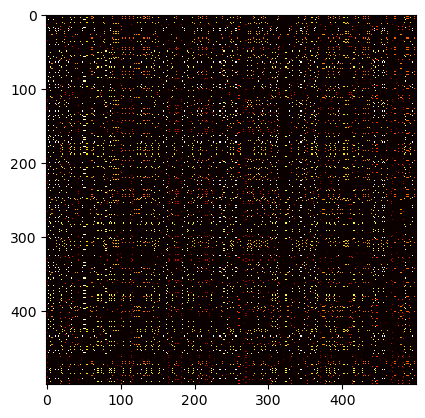

labelZero Matrix:  [[ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  3. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 ...
 [ 0.  0.  3. ...  0.  0.  0.]
 [12.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]]


In [78]:
plt.imshow(labelMatList[0].matrix, cmap='hot', interpolation='nearest')
plt.show()

print('labelZero Matrix: ', labelMatList[0].matrix)

## Merge coclustering results

In [13]:
# while biclusterList not empty
from coclusterSVD import isBiclusterIntersectGeneral
importlib.reload(ccSVD)
importlib.reload(bc)


count = 0
flag = True # if flag is True, then the item is not merged
while len(biclusterList) > 0:
    count += 1
    item : bc.bicluster = biclusterList.pop(0)
    for item_c in biclusterList:
        # concat the biclusterList
        if ccSVD.isBiclusterIntersectGeneral(bc1=item, bc2=item_c):
        # if True:
            # newRowIdx is OR(rowIdx, rowIdx_c)
            # e.g. rowIdx = [True, False, True], rowIdx_c = [False, True, True], newRowIdx = [True, True, True]
            newRowIdx = np.logical_or(item.row_idx, item_c.row_idx)
            newColIdx = np.logical_or(item.col_idx, item_c.col_idx)
            newScore = ccSVD.score(B, newRowIdx, newColIdx)
            print('newScore: ', newScore)
            # if newScore < item.score + item_c.score or newScore < 0.01:
            print('delta = ', newScore - item.score - item_c.score)
            print('item.score: ', item.score)
            print('item_c.score: ', item_c.score)
            print('-'*20)
            if newScore < item.score + item_c.score or newScore < 0.1:
                # replace item_c with new bicluster
                biclusterList.remove(item_c)
                biclusterList.append(bc.bicluster(newRowIdx, newColIdx, newScore))
                count = 0
                flag = False
                print('MERGED!')
                break
    if flag:
        biclusterList.append(item)
        flag = True
    if count > 2 * len(biclusterList):
        break
    
print('biclusterList.length: ', len(biclusterList))
            

newScore:  0.22745480186261413
delta =  0.22745480186261413
item.score:  0.0
item_c.score:  0.0
--------------------
newScore:  0.24874970707185862
delta =  0.24874970707185862
item.score:  0.0
item_c.score:  0.0
--------------------
newScore:  0.1517583433409806
delta =  0.1517583433409806
item.score:  0.0
item_c.score:  0.0
--------------------
newScore:  0.17436386535569237
delta =  0.07577637698601591
item.score:  0.0
item_c.score:  0.09858748836967646
--------------------
newScore:  0.24874970707185862
delta =  0.24874970707185862
item.score:  0.0
item_c.score:  0.0
--------------------
newScore:  0.22745480186261413
delta =  0.22745480186261413
item.score:  0.0
item_c.score:  0.0
--------------------
newScore:  0.17436386535569237
delta =  0.07577637698601591
item.score:  0.09858748836967646
item_c.score:  0.0
--------------------
newScore:  0.1517583433409806
delta =  0.1517583433409806
item.score:  0.0
item_c.score:  0.0
--------------------
newScore:  0.22745480186261413
delta

In [20]:
from coclusterSVD import isBiclusterIntersectGeneral
importlib.reload(ccSVD)
importlib.reload(bc)

# count number of intersection
count = 0
for i in range(len(biclusterList)):
    for j in range(i+1, len(biclusterList)):
        if ccSVD.isBiclusterIntersectGeneral(bc1=biclusterList[i], bc2=biclusterList[j]):
            count += 1
            
print('count: ', count)


count:  672


len(biclusterList):  20
row length:  31
col length:  26
score:  0.0
------------------
row length:  45
col length:  51
score:  0.0
------------------
row length:  48
col length:  30
score:  0.0
------------------
row length:  44
col length:  12
score:  0.0
------------------
row length:  14
col length:  19
score:  0.0
------------------
row length:  43
col length:  55
score:  0.0
------------------
row length:  36
col length:  34
score:  0.0
------------------
row length:  29
col length:  23
score:  0.0
------------------
row length:  33
col length:  33
score:  0.0
------------------
row length:  31
col length:  27
score:  0.0
------------------
row length:  27
col length:  32
score:  0.0
------------------
row length:  32
col length:  19
score:  0.0
------------------
row length:  27
col length:  20
score:  0.0
------------------
row length:  34
col length:  13
score:  0.0
------------------
row length:  22
col length:  25
score:  0.0
------------------
row length:  44
col length:  19

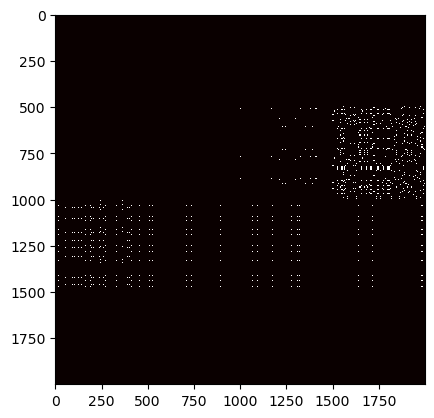

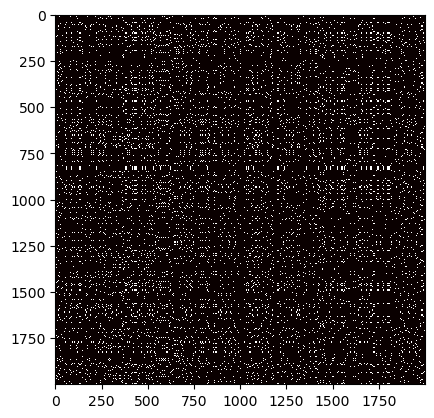

diff:  0.0506365


In [14]:
# print all length of biclusters
ite = 0
print('len(biclusterList): ', len(biclusterList))
resultOneZeroMat = np.zeros((M, N))
for item in biclusterList:
    # print('ite: ', ite)
    print('row length: ', np.sum(item.row_idx))
    # # print('row_size: ', item.row_idx.size)
    print('col length: ', np.sum(item.col_idx))
    # # print('col_size: ', item.col_idx.size)
    print('score: ', item.score)
    # print('row_idx: ', item.row_idx)
    # print('col_idx: ', item.col_idx)
    print('------------------')
    
    
    resultOneZeroMat[np.ix_(item.row_idx, item.col_idx)] = 1
    ite += 1
    
plt.imshow(resultOneZeroMat, cmap='hot', interpolation='nearest')
plt.show()

labelMatrixCut = labelMatrix > 0.5
plt.imshow(labelMatrixCut, cmap='hot', interpolation='nearest')
plt.show()

# print abs(showMat - labelMatrixCut) 
# print('diff: ', np.sum(showMat - labelMatrixCut)/M/N)
print('diff: ', np.sum(np.abs(resultOneZeroMat - labelMatrixCut))/M/N)

## TestA

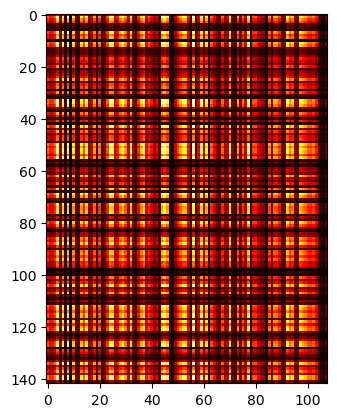

testScore:  0.25059402247221485
testA:  [[0.206 0.156 0.163 0.206 0.362 0.083 0.334 0.029 0.327 0.004]
 [0.522 0.396 0.415 0.524 0.919 0.211 0.849 0.073 0.83  0.01 ]
 [0.402 0.305 0.319 0.403 0.708 0.162 0.654 0.056 0.639 0.008]
 [0.329 0.25  0.261 0.33  0.579 0.133 0.535 0.046 0.523 0.006]
 [0.086 0.065 0.068 0.086 0.151 0.035 0.139 0.012 0.136 0.002]
 [0.086 0.065 0.068 0.086 0.151 0.035 0.139 0.012 0.136 0.002]
 [0.032 0.024 0.025 0.032 0.056 0.013 0.052 0.004 0.051 0.001]
 [0.475 0.361 0.378 0.477 0.838 0.192 0.773 0.066 0.757 0.009]
 [0.33  0.251 0.262 0.331 0.581 0.133 0.537 0.046 0.525 0.006]
 [0.389 0.295 0.309 0.39  0.685 0.157 0.632 0.054 0.618 0.007]]


In [81]:
# cluster1index = permx
testA = A[0:n[0], 0:m[0]]
plt.imshow(testA, cmap='hot', interpolation='nearest')
plt.show()
# testI is all true with shape (n[0],)
# testJ is all true with shape (m[0],)
testI = np.ones(n[0], dtype=bool)
testJ = np.ones(m[0], dtype=bool)

testScore = ccSVD.score(testA, testI, testJ)
print('testScore: ', testScore)

# print 10x10 of testA
print('testA: ', testA[0:10, 0:10])


In [82]:
# m[0]
# n[0]
print('m[0]: ', m[0])
print('n[0]: ', n[0])

# find range(0, n[0]) from permx and save it to IDX_I_one
# find range(0, m[0]) from permy and save it to IDX_J_one

IDX_I_one = permx[0:n[0]]
IDX_J_one = permy[0:m[0]]

# show limited to M // partition * N // partition submatrix
IDX_I_one = IDX_I_one[IDX_I_one < M // partition]
IDX_J_one = IDX_J_one[IDX_J_one < N // partition]

print('IDX_I_one: ', IDX_I_one)
print('IDX_J_one: ', IDX_J_one)

m[0]:  108
n[0]:  142
IDX_I_one:  [353  65  56 374 275 128  99  29 450 254 124 251  70 247 212 361 111 383 324 368  69 478 281 210
 297 429 239 256 382 352 494 393 464 366 306]
IDX_J_one:  [305 454 497  91 131 495 384 431 112  82  23  72 404 427 270 195  68]


## Work on one submatrix

### Get the small matrix

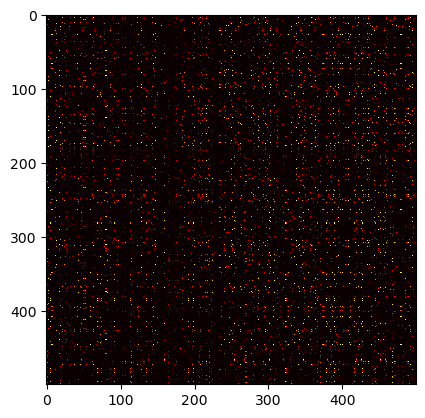

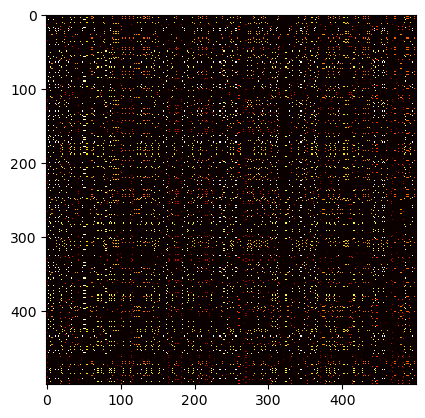

In [83]:
testB = subMatList[0]
testB_label = labelMatList[0]

plt.imshow(testB.matrix, cmap='hot', interpolation='nearest')
plt.show()

plt.imshow(testB_label.matrix, cmap='hot', interpolation='nearest')
plt.show()

In [84]:
ans = ccSVD.coclusterAtom(testB, tor=10e-2, k = 15, M=M, N=N)
print('ans: ', ans)

ans:  [bicluster(row_idx=array([False, False, False, ..., False, False, False]), col_idx=array([False, False, False, ..., False, False, False]), score=0.032978881688273454), bicluster(row_idx=array([False, False, False, ..., False, False, False]), col_idx=array([False, False, False, ..., False, False, False]), score=0.03094888569280496), bicluster(row_idx=array([False, False, False, ..., False, False, False]), col_idx=array([False, False, False, ..., False, False, False]), score=0.04075583806613625), bicluster(row_idx=array([False, False, False, ..., False, False, False]), col_idx=array([False, False, False, ..., False, False, False]), score=0.03917286664081199), bicluster(row_idx=array([False, False, False, ..., False, False, False]), col_idx=array([False, False, False, ..., False, False, False]), score=0.04951525137957935), bicluster(row_idx=array([False, False, False, ..., False, False, False]), col_idx=array([False,  True, False, ..., False, False, False]), score=0.0236318881630306

## Work on labelMatList[0]

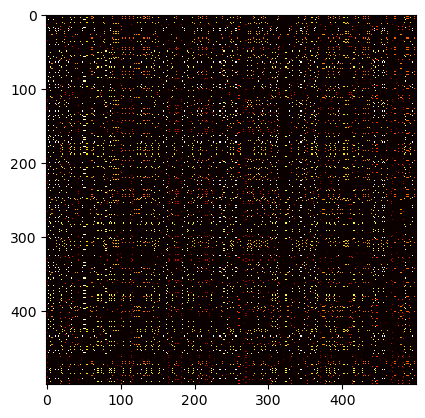

In [22]:
importlib.reload(ccSVD)
importlib.reload(bc)

# imshow B
plt.imshow(labelMatList[0].matrix, cmap='hot', interpolation='nearest')

U, S, Vh = np.linalg.svd(labelMatList[0].matrix, full_matrices=False)
C = np.dot(U, np.diag(S))

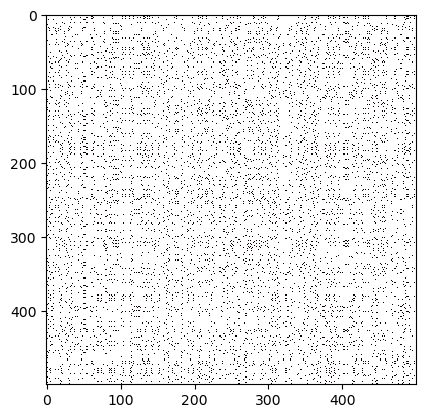

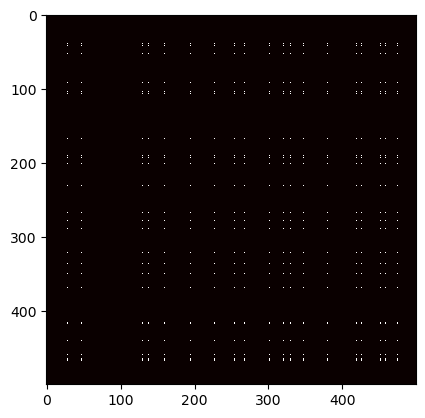

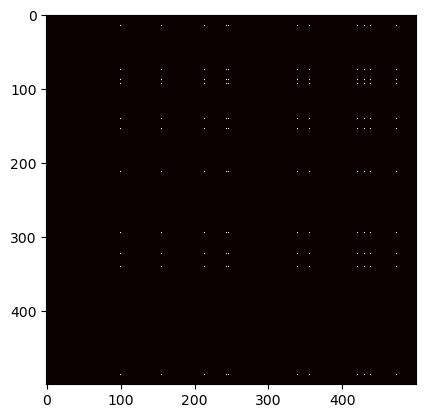

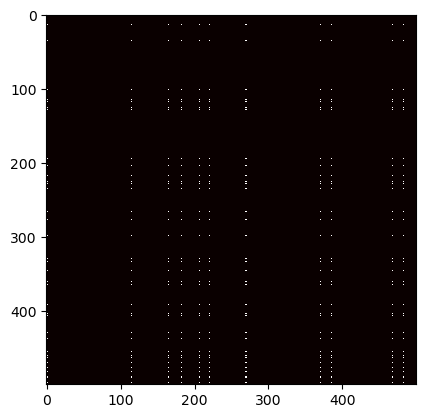

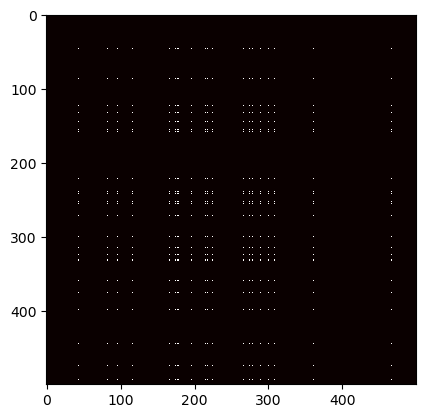

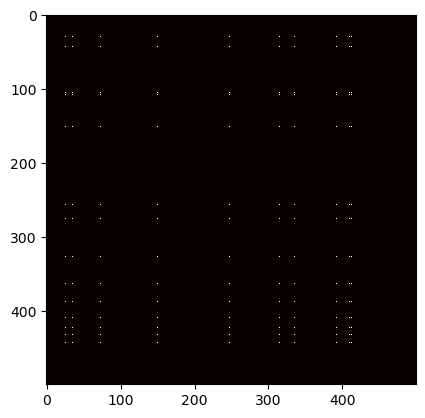

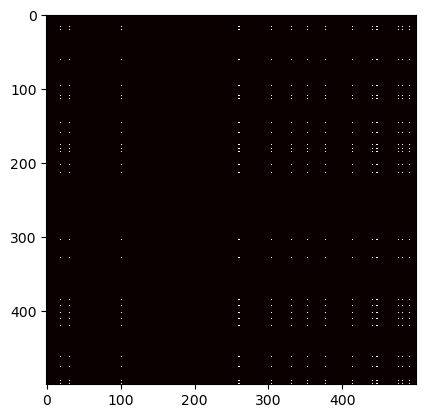

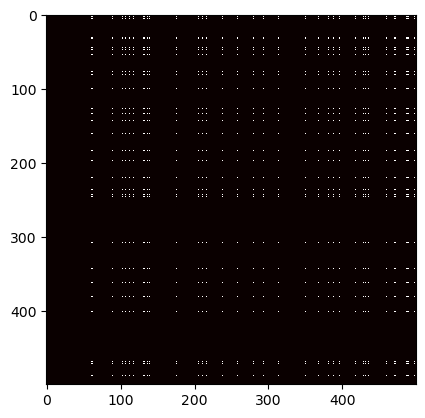

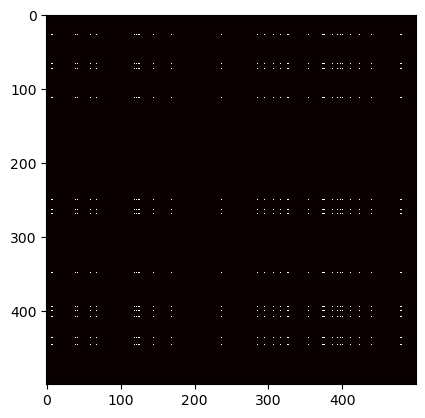

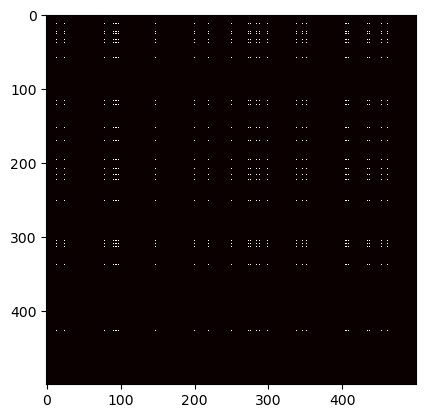

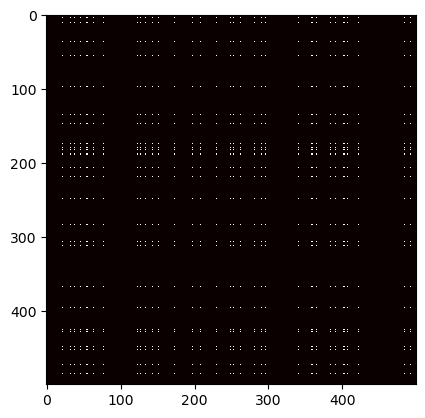

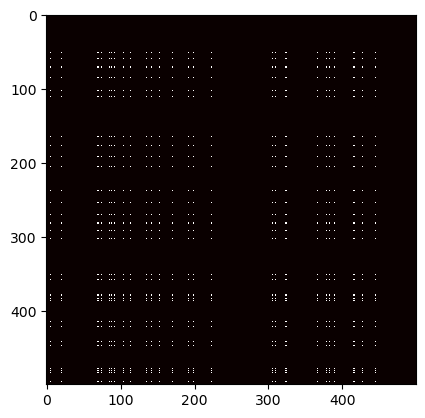

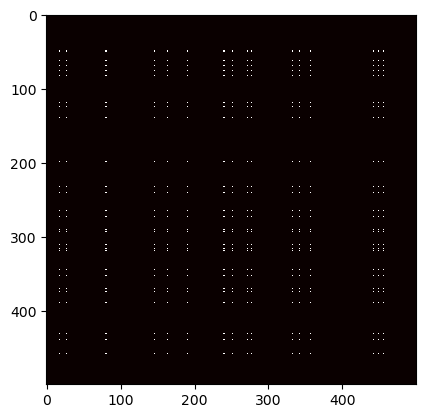

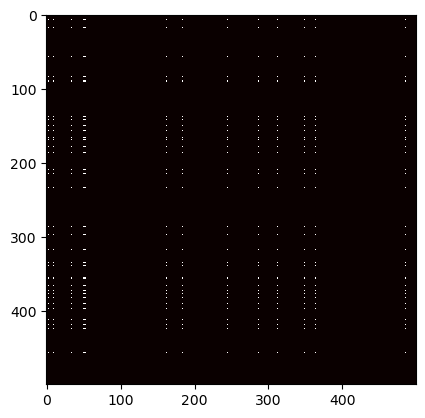

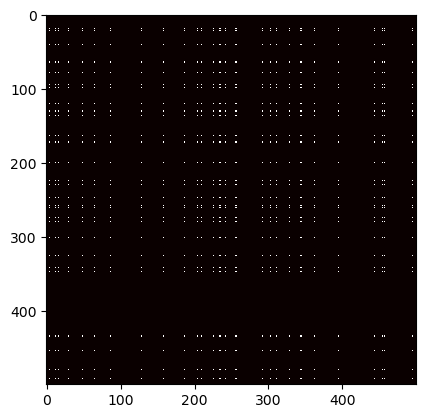

i:  bicluster(row_idx=array([ True, False, False, ..., False, False, False]), col_idx=array([False, False, False, ..., False, False, False]), score=0.0)
row length:  42
col length:  42
i.score:  0.0


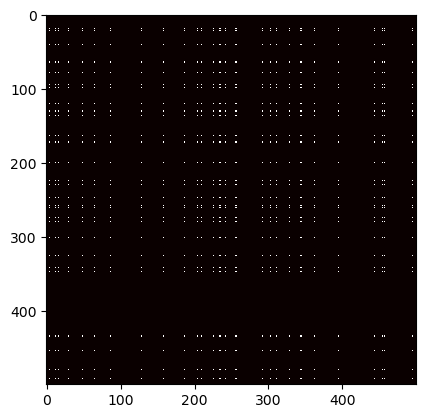

i:  bicluster(row_idx=array([ True, False, False, ..., False, False, False]), col_idx=array([False, False, False, ..., False, False, False]), score=0.09875082542994751)
row length:  42
col length:  19
i.score:  0.09875082542994751


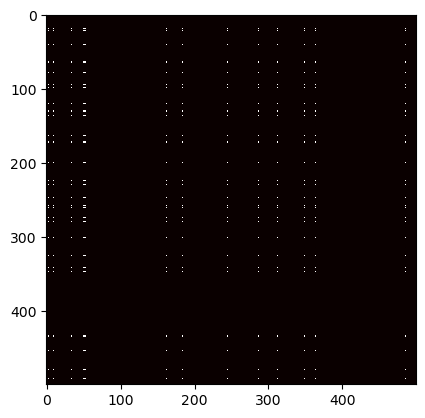

i:  bicluster(row_idx=array([ True, False, False, ..., False, False, False]), col_idx=array([False, False, False, ..., False, False, False]), score=0.08783283250184781)
row length:  42
col length:  13
i.score:  0.08783283250184781


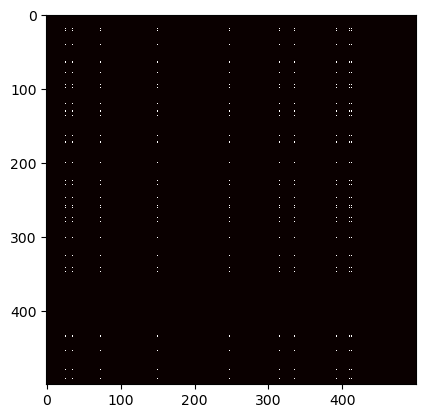

i:  bicluster(row_idx=array([ True, False, False, ..., False, False, False]), col_idx=array([False, False,  True, ..., False, False, False]), score=0.08899514202990455)
row length:  42
col length:  12
i.score:  0.08899514202990455


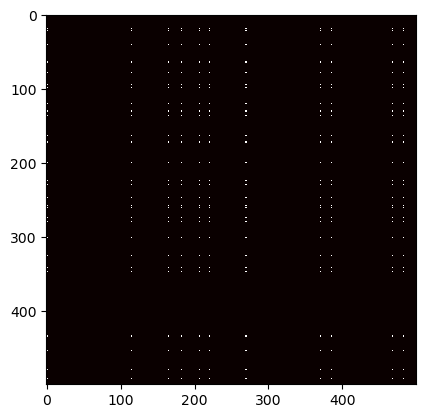

i:  bicluster(row_idx=array([ True, False, False, ..., False, False, False]), col_idx=array([False, False, False, ..., False, False, False]), score=0.09326602070844303)
row length:  42
col length:  15
i.score:  0.09326602070844303


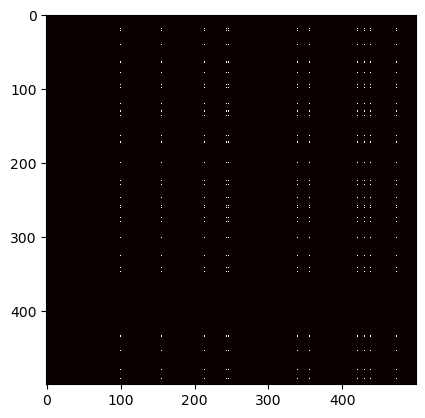

i:  bicluster(row_idx=array([False, False, False, ..., False, False, False]), col_idx=array([False, False, False, ..., False, False, False]), score=0.09314493958173775)
row length:  19
col length:  84
i.score:  0.09314493958173775


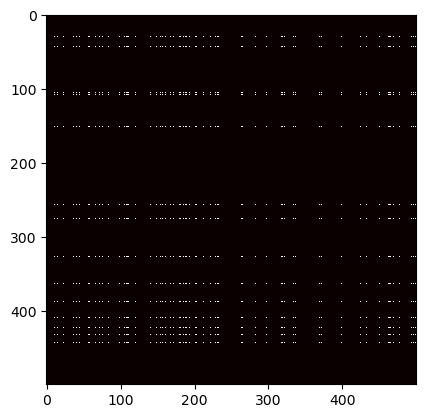

i:  bicluster(row_idx=array([False, False, False, ..., False, False, False]), col_idx=array([False,  True, False, ..., False, False, False]), score=0.09789232249390922)
row length:  19
col length:  36
i.score:  0.09789232249390922


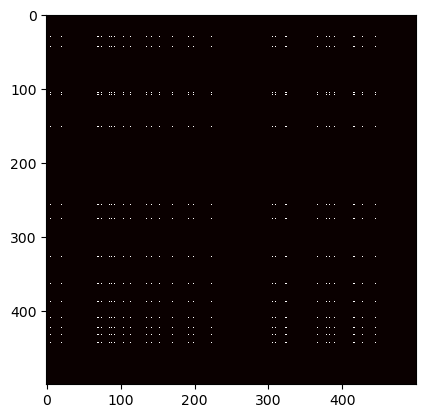

i:  bicluster(row_idx=array([False, False, False, ..., False, False, False]), col_idx=array([False, False, False, ..., False, False, False]), score=0.0)
row length:  19
col length:  13
i.score:  0.0


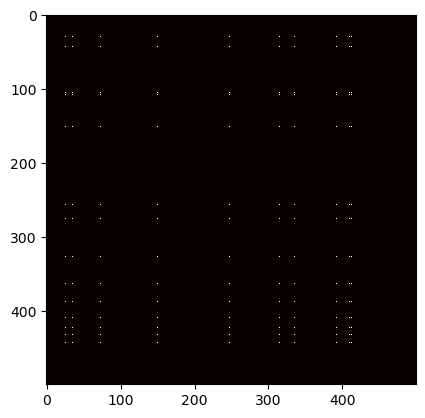

i:  bicluster(row_idx=array([False, False, False, ..., False, False, False]), col_idx=array([False, False,  True, ..., False, False, False]), score=0.0881951602878649)
row length:  19
col length:  12
i.score:  0.0881951602878649


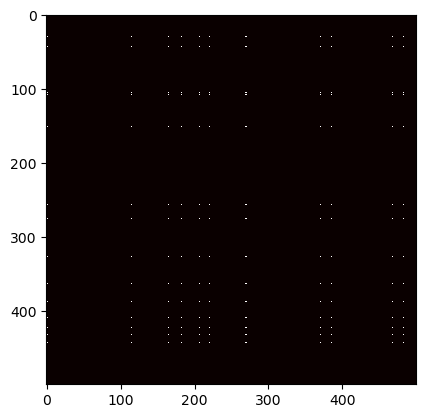

i:  bicluster(row_idx=array([False, False, False, ..., False, False, False]), col_idx=array([False, False, False, ..., False, False, False]), score=0.09882602809761398)
row length:  19
col length:  24
i.score:  0.09882602809761398


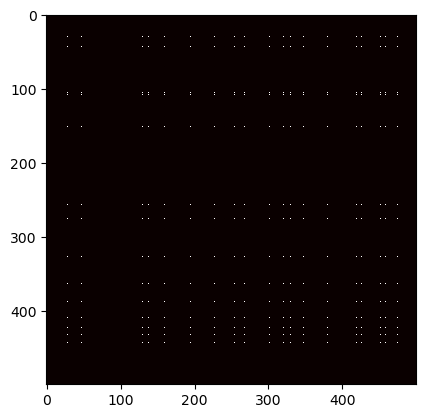

i:  bicluster(row_idx=array([False, False, False, ..., False, False, False]), col_idx=array([False, False, False, ..., False, False, False]), score=0.09537241403699803)
row length:  19
col length:  15
i.score:  0.09537241403699803


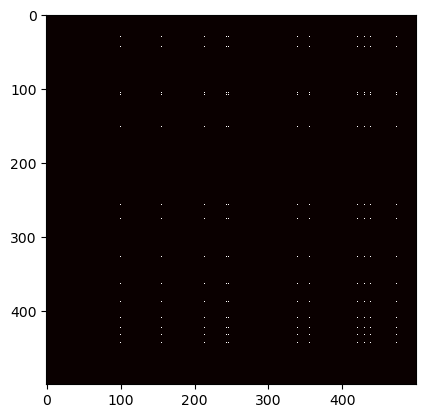

i:  bicluster(row_idx=array([False, False, False, ..., False, False, False]), col_idx=array([ True, False, False, ..., False, False, False]), score=0.0)
row length:  44
col length:  31
i.score:  0.0


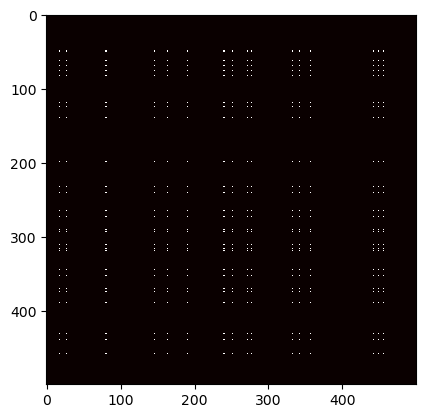

i:  bicluster(row_idx=array([False, False, False, ..., False, False, False]), col_idx=array([False, False, False, ..., False, False, False]), score=0.08747633865133075)
row length:  44
col length:  13
i.score:  0.08747633865133075


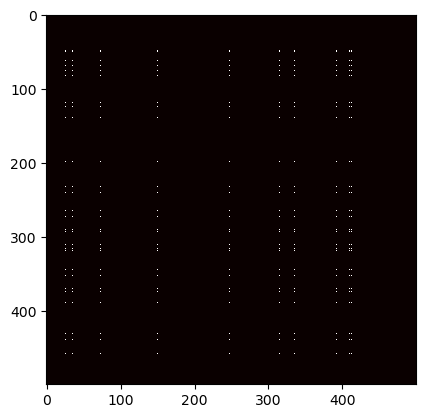

i:  bicluster(row_idx=array([False, False, False, ..., False, False, False]), col_idx=array([False, False,  True, ..., False, False, False]), score=0.0939021225370622)
row length:  44
col length:  12
i.score:  0.0939021225370622


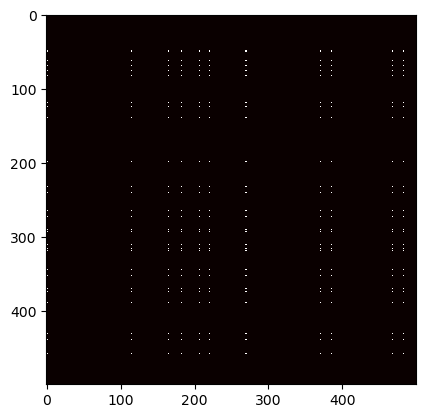

i:  bicluster(row_idx=array([False, False, False, ..., False, False, False]), col_idx=array([False, False, False, ..., False, False, False]), score=0.08937579532709994)
row length:  44
col length:  15
i.score:  0.08937579532709994


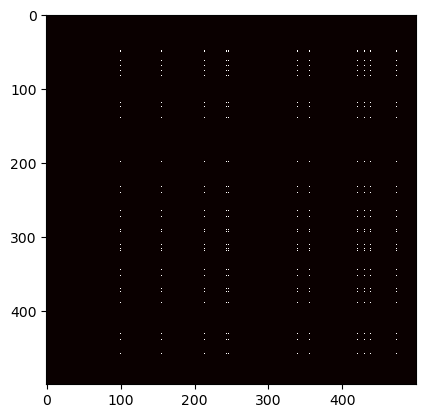

i:  bicluster(row_idx=array([False, False,  True, ..., False, False, False]), col_idx=array([ True, False, False, ..., False, False, False]), score=0.09736936478683977)
row length:  36
col length:  31
i.score:  0.09736936478683977


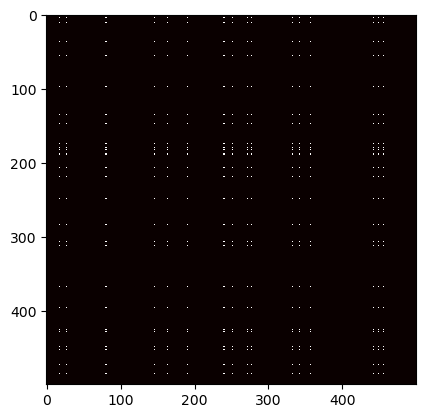

i:  bicluster(row_idx=array([False, False,  True, ..., False, False, False]), col_idx=array([False, False, False, ..., False, False, False]), score=0.0)
row length:  36
col length:  52
i.score:  0.0


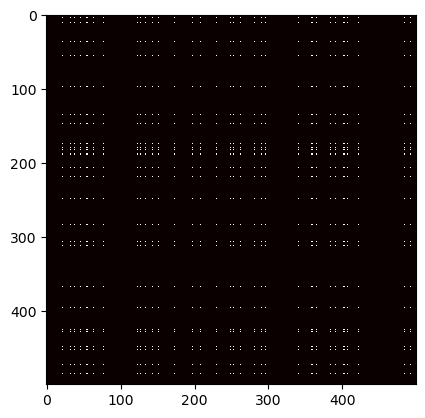

i:  bicluster(row_idx=array([False, False,  True, ..., False, False, False]), col_idx=array([False, False, False, ..., False, False, False]), score=0.09568812759687084)
row length:  36
col length:  13
i.score:  0.09568812759687084


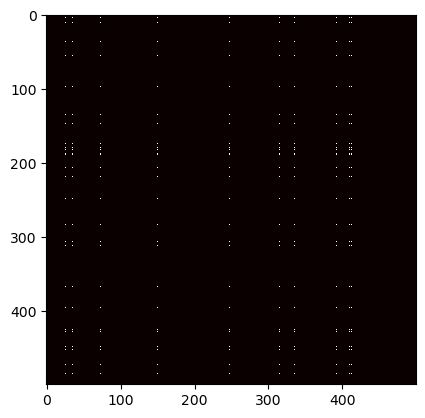

i:  bicluster(row_idx=array([False, False,  True, ..., False, False, False]), col_idx=array([False, False,  True, ..., False, False, False]), score=0.09274274412919448)
row length:  36
col length:  12
i.score:  0.09274274412919448


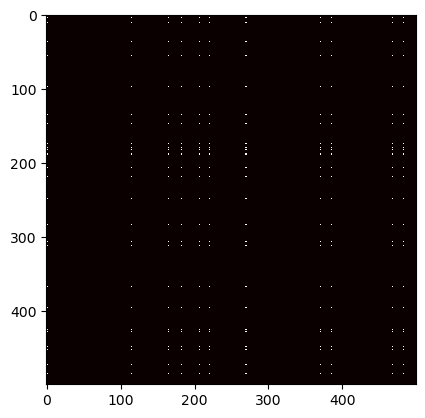

i:  bicluster(row_idx=array([False, False, False, ..., False, False, False]), col_idx=array([False, False, False, ..., False, False, False]), score=0.0)
row length:  46
col length:  19
i.score:  0.0


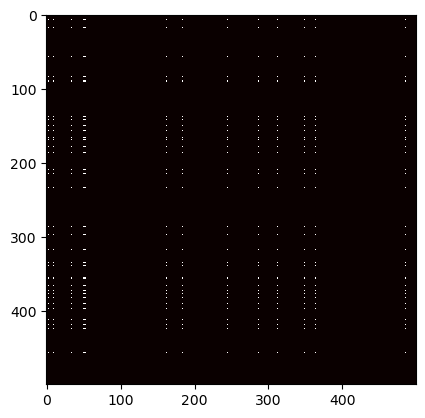

i:  bicluster(row_idx=array([False, False, False, ..., False, False, False]), col_idx=array([False, False, False, ..., False, False, False]), score=0.08333468873686722)
row length:  46
col length:  13
i.score:  0.08333468873686722


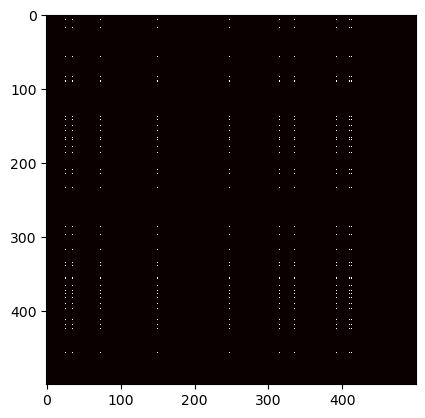

i:  bicluster(row_idx=array([False, False, False, ..., False, False, False]), col_idx=array([False, False, False, ..., False, False, False]), score=0.09237075736660028)
row length:  37
col length:  19
i.score:  0.09237075736660028


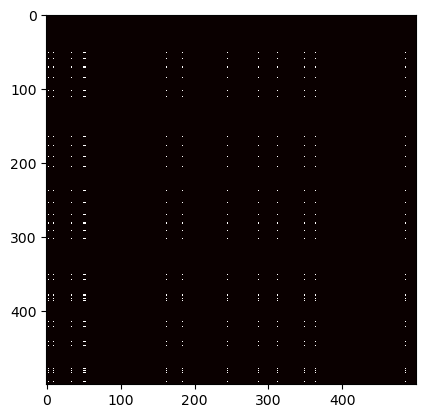

i:  bicluster(row_idx=array([False, False, False, ..., False, False, False]), col_idx=array([False,  True, False, ..., False, False, False]), score=0.0)
row length:  37
col length:  36
i.score:  0.0


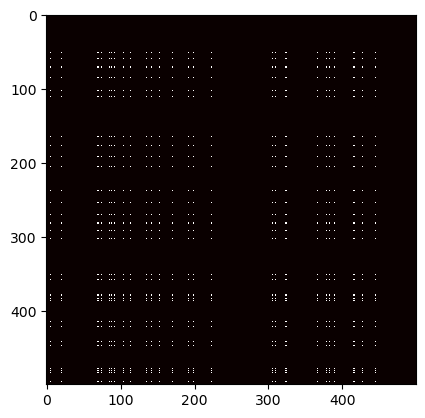

i:  bicluster(row_idx=array([False, False, False, ..., False, False, False]), col_idx=array([False, False, False, ..., False, False, False]), score=0.09855741697834008)
row length:  37
col length:  38
i.score:  0.09855741697834008


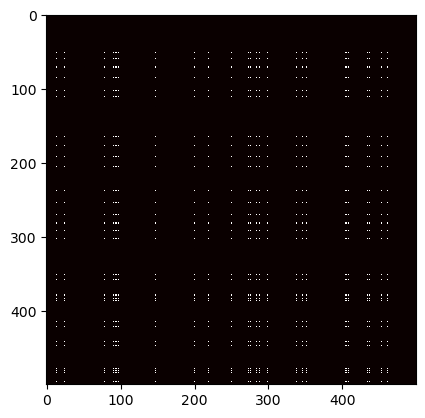

i:  bicluster(row_idx=array([False, False, False, ..., False, False, False]), col_idx=array([False, False,  True, ..., False, False, False]), score=0.081467275271501)
row length:  37
col length:  12
i.score:  0.081467275271501


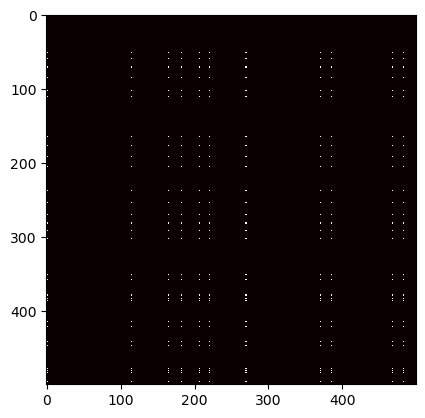

i:  bicluster(row_idx=array([False, False, False, ..., False, False, False]), col_idx=array([False, False, False, ..., False, False, False]), score=0.0977114372578538)
row length:  37
col length:  24
i.score:  0.0977114372578538


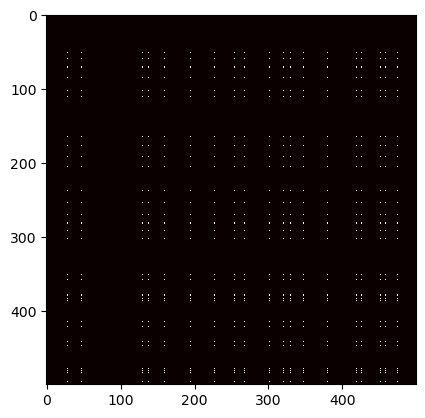

i:  bicluster(row_idx=array([False, False, False, ..., False, False, False]), col_idx=array([False, False, False, ..., False, False, False]), score=0.09885414686405192)
row length:  26
col length:  84
i.score:  0.09885414686405192


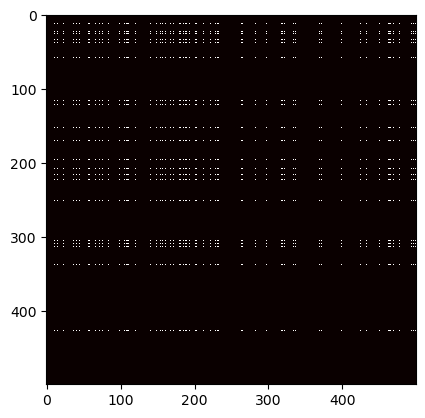

i:  bicluster(row_idx=array([False, False, False, ..., False, False, False]), col_idx=array([False,  True, False, ..., False, False, False]), score=0.09792547764662696)
row length:  26
col length:  36
i.score:  0.09792547764662696


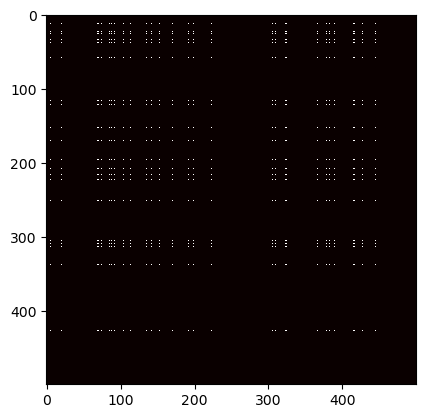

i:  bicluster(row_idx=array([False, False, False, ..., False, False, False]), col_idx=array([False, False, False, ..., False, False, False]), score=0.0)
row length:  26
col length:  38
i.score:  0.0


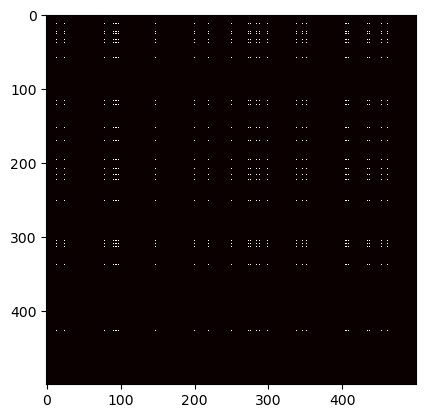

i:  bicluster(row_idx=array([False, False, False, ..., False, False, False]), col_idx=array([False, False, False, ..., False, False, False]), score=0.08602070046590482)
row length:  26
col length:  20
i.score:  0.08602070046590482


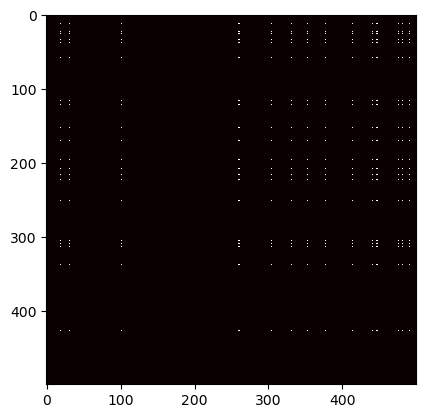

i:  bicluster(row_idx=array([False, False, False, ..., False, False, False]), col_idx=array([False, False, False, ..., False, False, False]), score=0.09571249598626974)
row length:  26
col length:  13
i.score:  0.09571249598626974


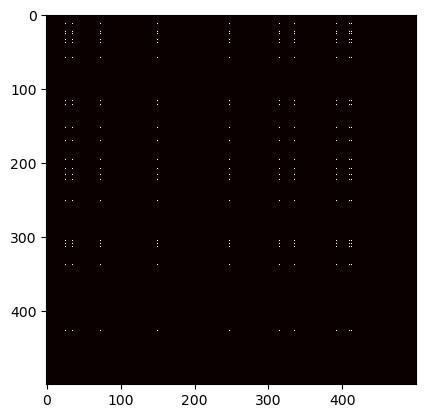

i:  bicluster(row_idx=array([False, False, False, ..., False, False, False]), col_idx=array([False, False,  True, ..., False, False, False]), score=0.08886701403194097)
row length:  26
col length:  12
i.score:  0.08886701403194097


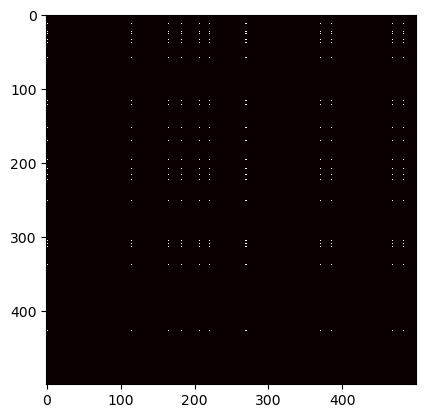

i:  bicluster(row_idx=array([False, False, False, ..., False, False, False]), col_idx=array([False, False, False, ..., False, False, False]), score=0.09111484416166615)
row length:  26
col length:  15
i.score:  0.09111484416166615


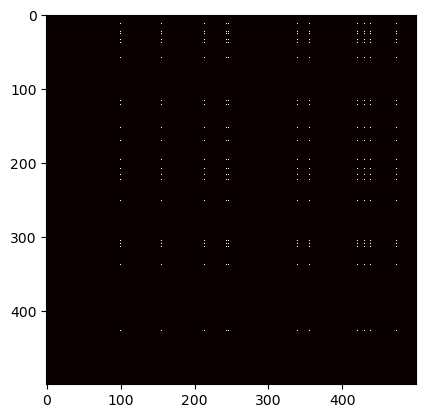

i:  bicluster(row_idx=array([False, False, False, ..., False, False, False]), col_idx=array([False, False, False, ..., False, False, False]), score=0.0)
row length:  34
col length:  46
i.score:  0.0


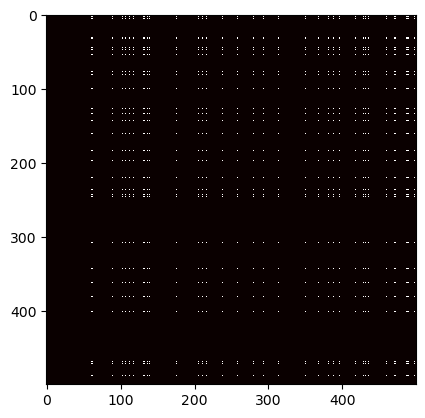

i:  bicluster(row_idx=array([False, False, False, ..., False, False, False]), col_idx=array([False, False, False, ..., False, False, False]), score=0.09721910919252508)
row length:  34
col length:  25
i.score:  0.09721910919252508


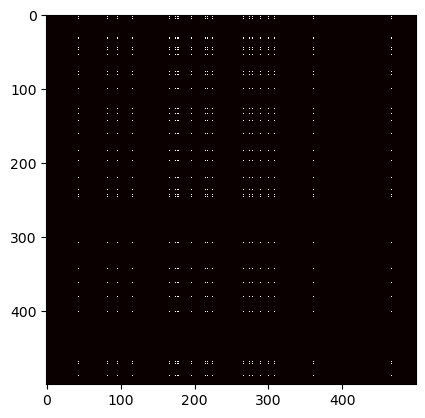

i:  bicluster(row_idx=array([False, False, False, ..., False, False, False]), col_idx=array([False, False, False, ..., False, False, False]), score=0.08678758345577997)
row length:  34
col length:  13
i.score:  0.08678758345577997


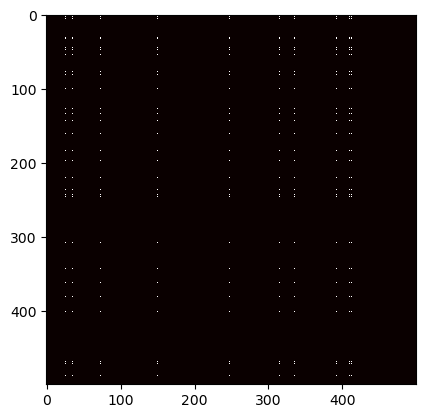

i:  bicluster(row_idx=array([False, False, False, ..., False, False, False]), col_idx=array([False, False, False, ..., False, False, False]), score=0.08951147266468151)
row length:  34
col length:  15
i.score:  0.08951147266468151


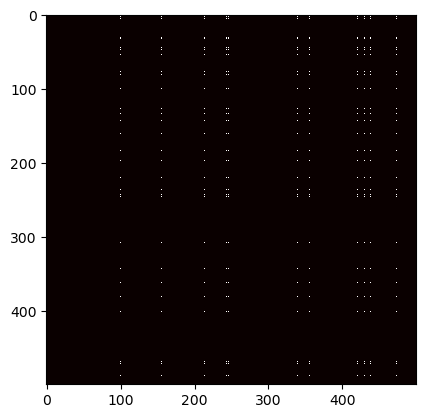

i:  bicluster(row_idx=array([False, False, False, ..., False, False, False]), col_idx=array([False, False, False, ..., False, False, False]), score=0.09298755948868553)
row length:  22
col length:  84
i.score:  0.09298755948868553


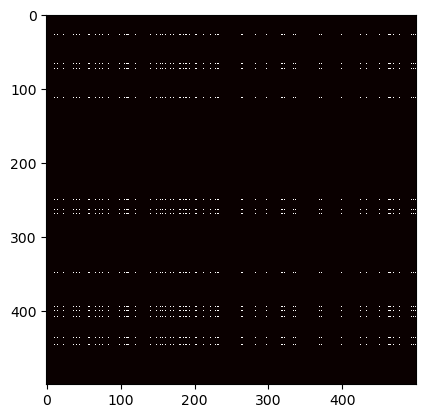

i:  bicluster(row_idx=array([False, False, False, ..., False, False, False]), col_idx=array([ True, False, False, ..., False, False, False]), score=0.0992515262678485)
row length:  22
col length:  31
i.score:  0.0992515262678485


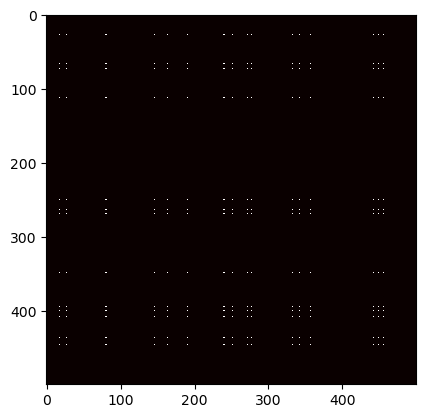

i:  bicluster(row_idx=array([False, False, False, ..., False, False, False]), col_idx=array([False, False, False, ..., False, False, False]), score=0.0927108533287031)
row length:  22
col length:  19
i.score:  0.0927108533287031


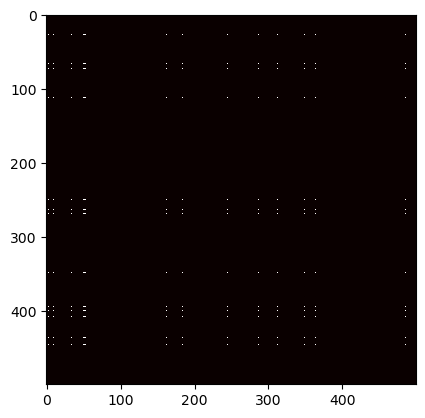

i:  bicluster(row_idx=array([False, False, False, ..., False, False, False]), col_idx=array([False, False, False, ..., False, False, False]), score=0.0)
row length:  22
col length:  43
i.score:  0.0


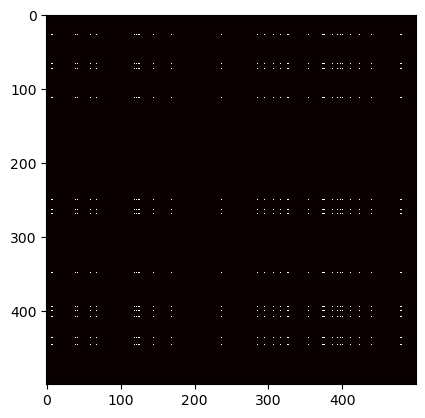

i:  bicluster(row_idx=array([False, False, False, ..., False, False, False]), col_idx=array([False, False, False, ..., False, False, False]), score=0.0999007951466847)
row length:  22
col length:  25
i.score:  0.0999007951466847


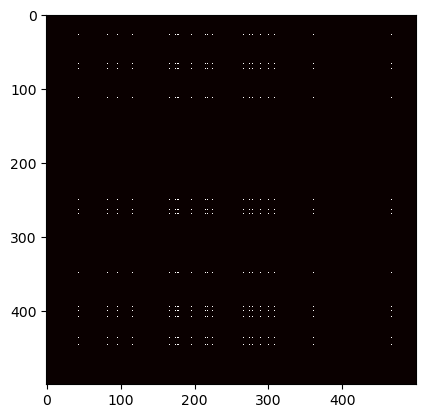

i:  bicluster(row_idx=array([False, False, False, ..., False, False, False]), col_idx=array([False, False,  True, ..., False, False, False]), score=0.09888930489310055)
row length:  22
col length:  12
i.score:  0.09888930489310055


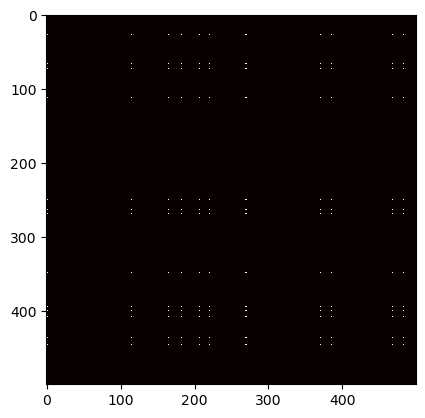

i:  bicluster(row_idx=array([False, False, False, ..., False, False, False]), col_idx=array([False, False, False, ..., False, False, False]), score=0.09765043684813712)
row length:  22
col length:  15
i.score:  0.09765043684813712


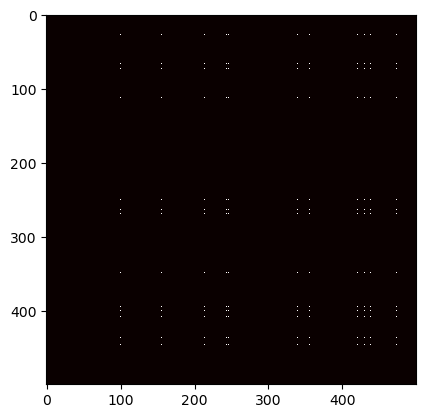

i:  bicluster(row_idx=array([False, False, False, ..., False, False, False]), col_idx=array([False, False, False, ..., False, False, False]), score=0.09830094242226761)
row length:  14
col length:  84
i.score:  0.09830094242226761


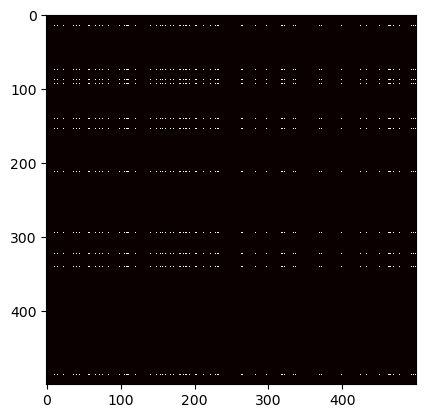

i:  bicluster(row_idx=array([False, False, False, ..., False, False, False]), col_idx=array([ True, False, False, ..., False, False, False]), score=0.090759521997411)
row length:  14
col length:  31
i.score:  0.090759521997411


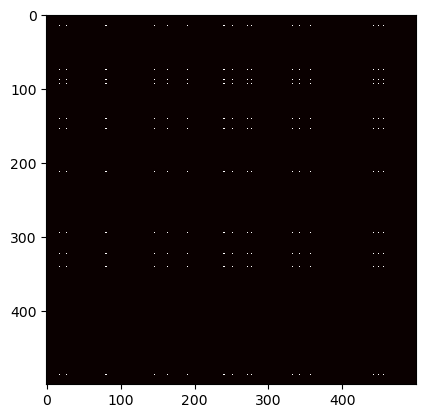

i:  bicluster(row_idx=array([False, False, False, ..., False, False, False]), col_idx=array([False, False, False, ..., False, False, False]), score=0.09797142164186012)
row length:  14
col length:  42
i.score:  0.09797142164186012


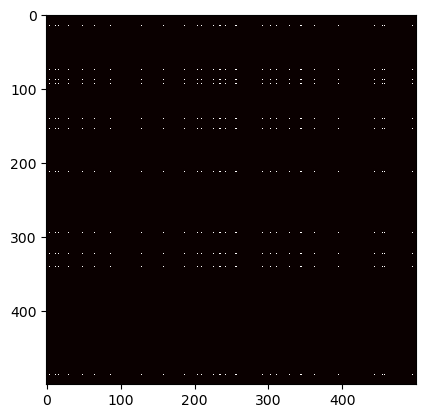

i:  bicluster(row_idx=array([False, False, False, ..., False, False, False]), col_idx=array([False, False, False, ..., False, False, False]), score=0.09829138579920904)
row length:  14
col length:  52
i.score:  0.09829138579920904


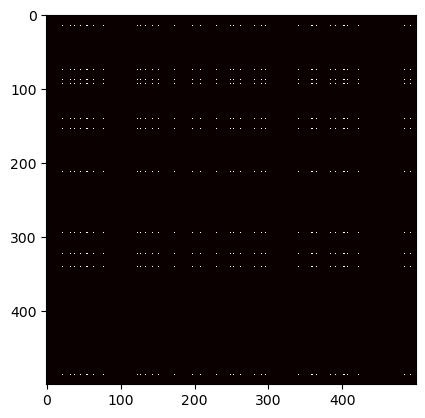

i:  bicluster(row_idx=array([False, False, False, ..., False, False, False]), col_idx=array([False, False, False, ..., False, False, False]), score=0.09376042111313332)
row length:  14
col length:  19
i.score:  0.09376042111313332


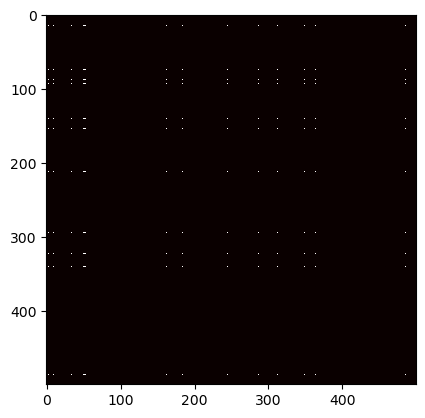

i:  bicluster(row_idx=array([False, False, False, ..., False, False, False]), col_idx=array([False,  True, False, ..., False, False, False]), score=0.08420334372894467)
row length:  14
col length:  36
i.score:  0.08420334372894467


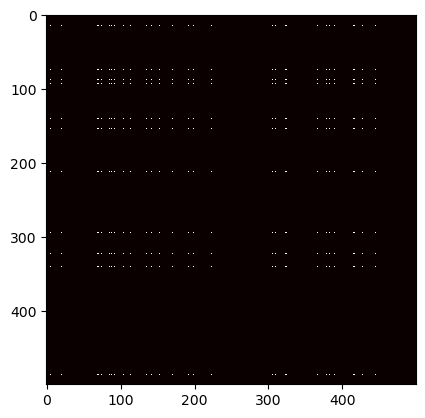

i:  bicluster(row_idx=array([False, False, False, ..., False, False, False]), col_idx=array([False, False, False, ..., False, False, False]), score=0.08397240619966051)
row length:  14
col length:  38
i.score:  0.08397240619966051


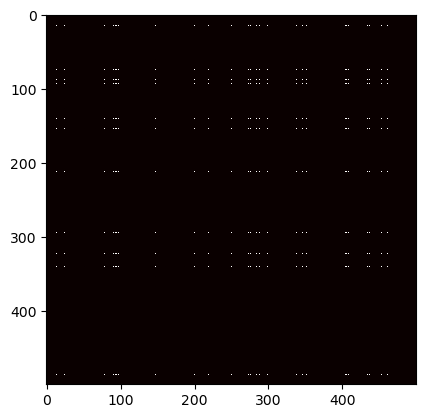

i:  bicluster(row_idx=array([False, False, False, ..., False, False, False]), col_idx=array([False, False, False, ..., False, False, False]), score=0.09695740339236136)
row length:  14
col length:  43
i.score:  0.09695740339236136


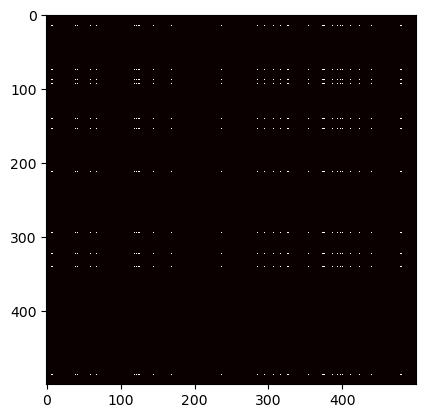

i:  bicluster(row_idx=array([False, False, False, ..., False, False, False]), col_idx=array([False, False, False, ..., False, False, False]), score=0.09676518788538224)
row length:  14
col length:  46
i.score:  0.09676518788538224


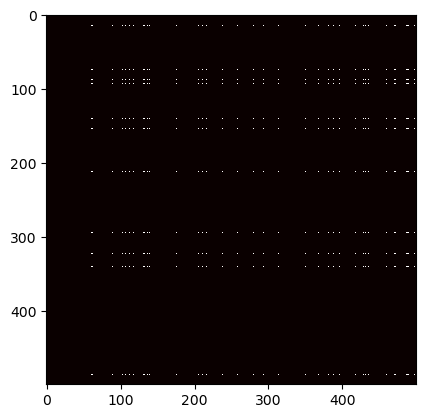

i:  bicluster(row_idx=array([False, False, False, ..., False, False, False]), col_idx=array([False, False,  True, ..., False, False, False]), score=0.09925175510881379)
row length:  14
col length:  12
i.score:  0.09925175510881379


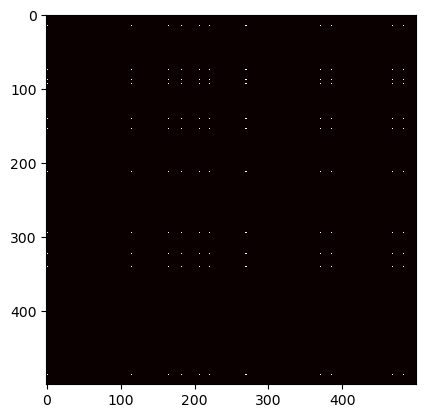

i:  bicluster(row_idx=array([False, False, False, ..., False, False, False]), col_idx=array([False, False, False, ..., False, False, False]), score=0.0)
row length:  14
col length:  15
i.score:  0.0


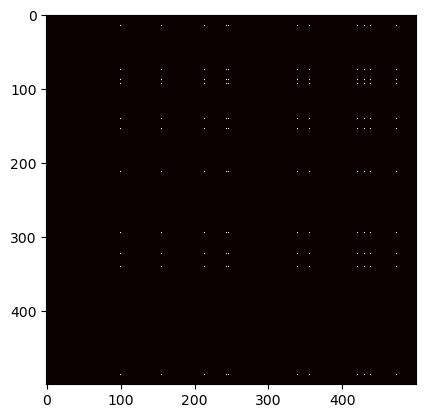

i:  bicluster(row_idx=array([False, False, False, ..., False, False, False]), col_idx=array([False, False, False, ..., False, False, False]), score=0.09767753736713647)
row length:  32
col length:  46
i.score:  0.09767753736713647


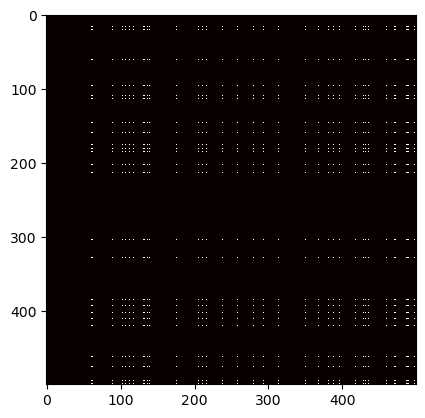

i:  bicluster(row_idx=array([False, False, False, ..., False, False, False]), col_idx=array([False, False, False, ..., False, False, False]), score=0.0)
row length:  32
col length:  20
i.score:  0.0


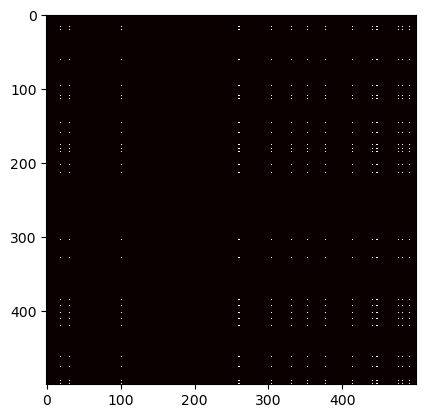

i:  bicluster(row_idx=array([False, False, False, ..., False, False, False]), col_idx=array([False, False,  True, ..., False, False, False]), score=0.09037646368684471)
row length:  32
col length:  12
i.score:  0.09037646368684471


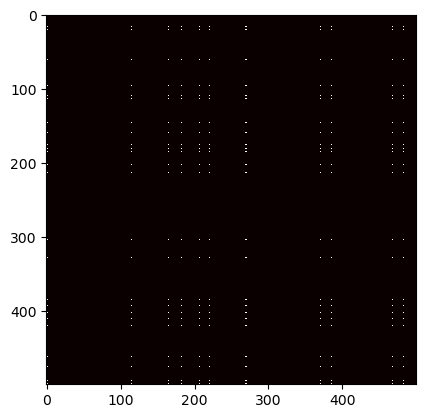

i:  bicluster(row_idx=array([False, False, False, ..., False, False, False]), col_idx=array([False, False, False, ..., False, False, False]), score=0.09924693757700875)
row length:  32
col length:  15
i.score:  0.09924693757700875


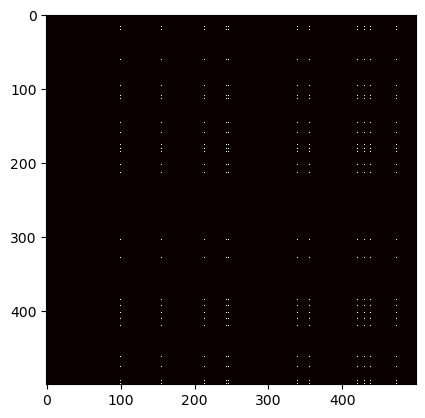

i:  bicluster(row_idx=array([False, False, False, ..., False, False, False]), col_idx=array([False, False, False, ..., False, False, False]), score=0.09653961226965446)
row length:  33
col length:  84
i.score:  0.09653961226965446


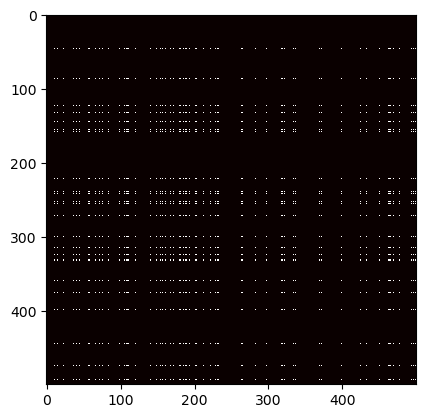

i:  bicluster(row_idx=array([False, False, False, ..., False, False, False]), col_idx=array([False,  True, False, ..., False, False, False]), score=0.09961134423079487)
row length:  33
col length:  36
i.score:  0.09961134423079487


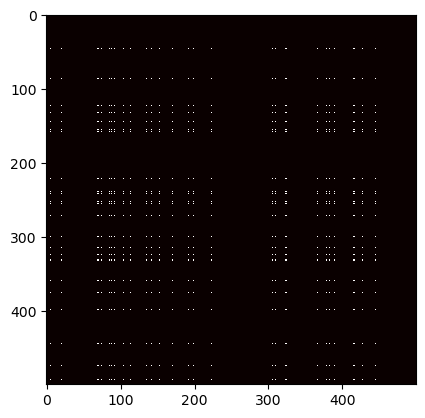

i:  bicluster(row_idx=array([False, False, False, ..., False, False, False]), col_idx=array([False, False, False, ..., False, False, False]), score=0.09068168461348369)
row length:  33
col length:  46
i.score:  0.09068168461348369


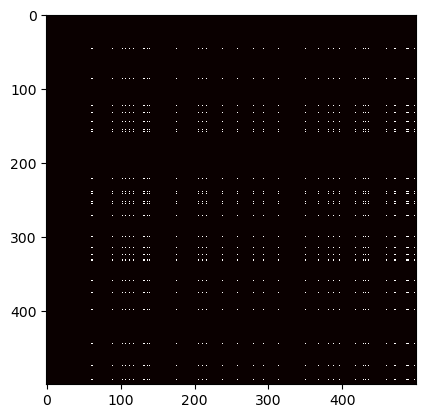

i:  bicluster(row_idx=array([False, False, False, ..., False, False, False]), col_idx=array([False, False, False, ..., False, False, False]), score=0.0)
row length:  33
col length:  25
i.score:  0.0


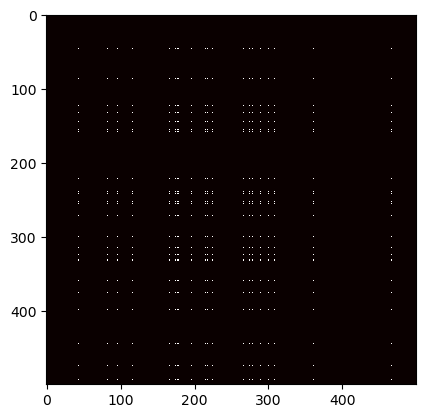

i:  bicluster(row_idx=array([False, False, False, ..., False, False, False]), col_idx=array([False, False, False, ..., False, False, False]), score=0.0999746893648571)
row length:  33
col length:  13
i.score:  0.0999746893648571


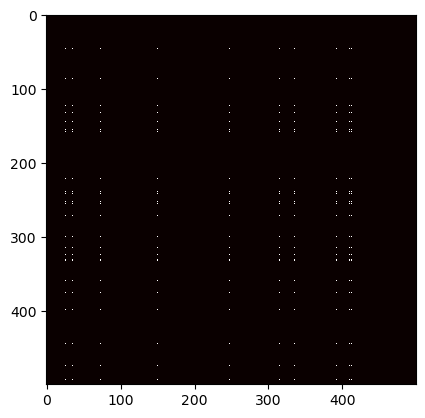

i:  bicluster(row_idx=array([False, False, False, ..., False, False, False]), col_idx=array([False, False,  True, ..., False, False, False]), score=0.09595472763112689)
row length:  33
col length:  12
i.score:  0.09595472763112689


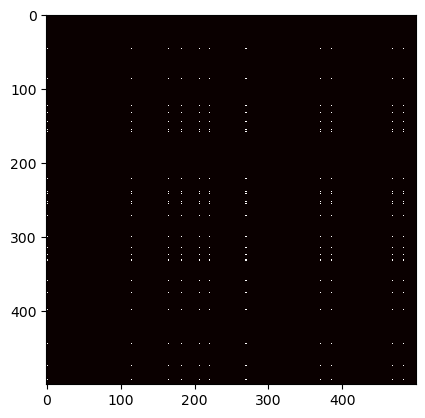

i:  bicluster(row_idx=array([False, False, False, ..., False, False, False]), col_idx=array([False, False, False, ..., False, False, False]), score=0.09128559977930228)
row length:  33
col length:  13
i.score:  0.09128559977930228


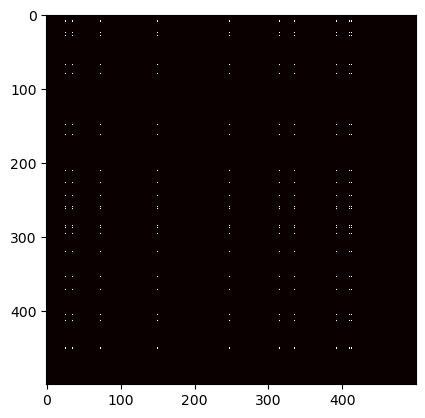

i:  bicluster(row_idx=array([False, False, False, ..., False, False, False]), col_idx=array([False, False,  True, ..., False, False, False]), score=0.09235136948812794)
row length:  33
col length:  12
i.score:  0.09235136948812794


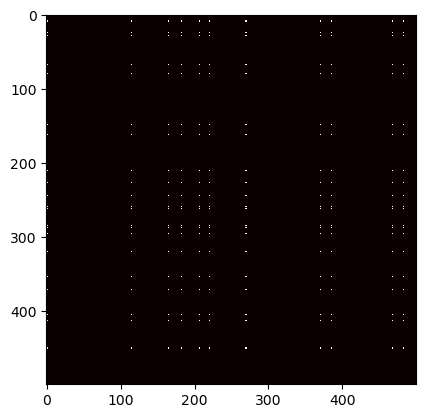

i:  bicluster(row_idx=array([False, False, False, ..., False, False, False]), col_idx=array([False, False, False, ..., False, False, False]), score=0.09567214130282409)
row length:  33
col length:  15
i.score:  0.09567214130282409


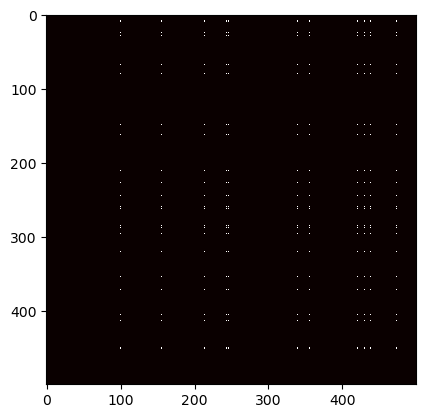

i:  bicluster(row_idx=array([False,  True, False, ..., False, False, False]), col_idx=array([False, False, False, ..., False, False, False]), score=0.09098581275534279)
row length:  46
col length:  13
i.score:  0.09098581275534279


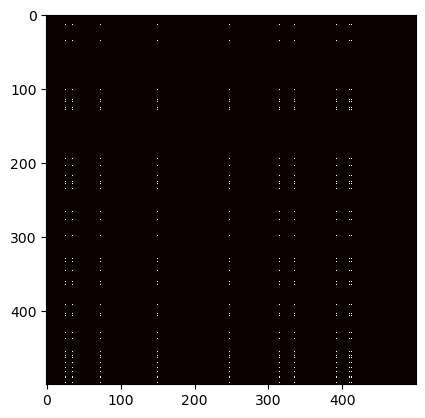

i:  bicluster(row_idx=array([False,  True, False, ..., False, False, False]), col_idx=array([False, False,  True, ..., False, False, False]), score=0.0)
row length:  46
col length:  12
i.score:  0.0


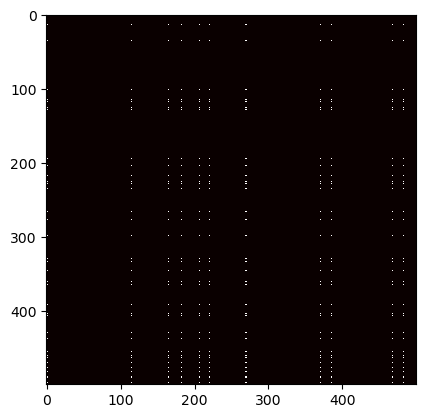

i:  bicluster(row_idx=array([False,  True, False, ..., False, False, False]), col_idx=array([False, False, False, ..., False, False, False]), score=0.09285358055110005)
row length:  46
col length:  15
i.score:  0.09285358055110005


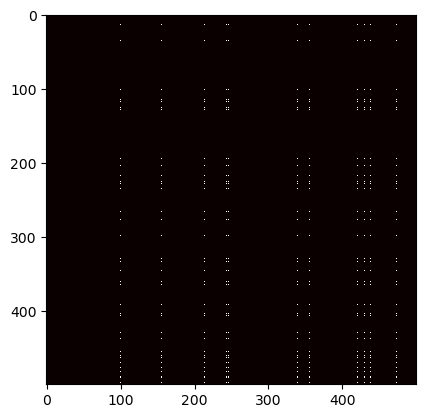

i:  bicluster(row_idx=array([False, False, False, ..., False, False, False]), col_idx=array([False, False, False, ..., False, False, False]), score=0.09782734132570114)
row length:  36
col length:  20
i.score:  0.09782734132570114


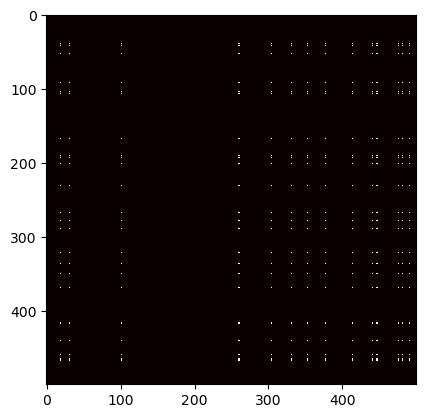

i:  bicluster(row_idx=array([False, False, False, ..., False, False, False]), col_idx=array([False, False, False, ..., False, False, False]), score=0.0965947479031718)
row length:  36
col length:  25
i.score:  0.0965947479031718


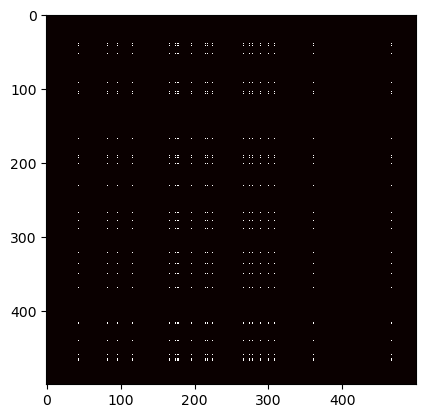

i:  bicluster(row_idx=array([False, False, False, ..., False, False, False]), col_idx=array([False, False, False, ..., False, False, False]), score=0.09257861531756995)
row length:  36
col length:  13
i.score:  0.09257861531756995


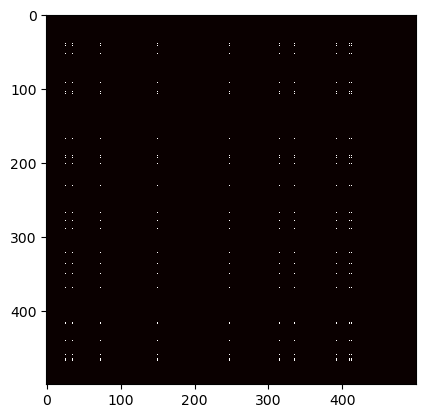

i:  bicluster(row_idx=array([False, False, False, ..., False, False, False]), col_idx=array([False, False,  True, ..., False, False, False]), score=0.09579157176320496)
row length:  36
col length:  12
i.score:  0.09579157176320496


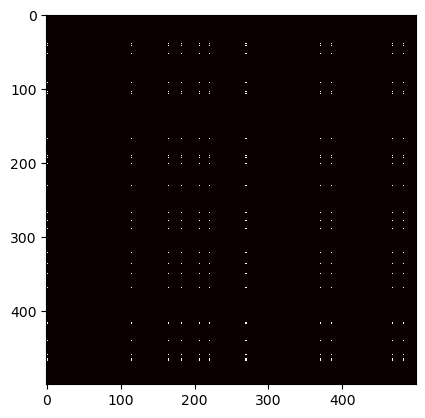

i:  bicluster(row_idx=array([False, False, False, ..., False, False, False]), col_idx=array([False, False, False, ..., False, False, False]), score=0.0)
row length:  36
col length:  24
i.score:  0.0


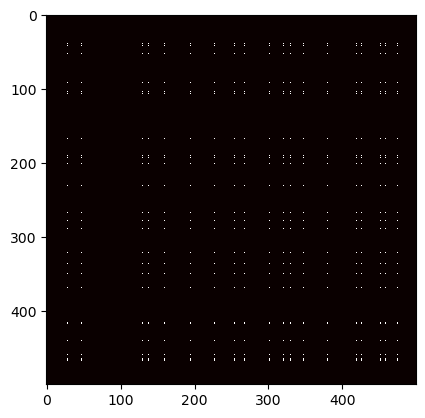

In [31]:
testLabelMat = labelMatList[0]
ansBiList = ccSVD.coclusterAtom(testLabelMat, tor=10e-2, k = 15, M=M, N=N)

# show testLabelMat.matrix == i
for i in range(num_bicluster):
    plt.imshow(testLabelMat.matrix == i, cmap='hot', interpolation='nearest')
    plt.show()
    


for i in ansBiList:
    print('i: ', i)
    print('row length: ', np.sum(i.row_idx))
    print('col length: ', np.sum(i.col_idx))
    print('i.score: ', i.score)
    
    showMat = np.zeros(testLabelMat.matrix.shape)
    showMat[np.ix_(i.row_idx, i.col_idx)] = 1
    plt.imshow(showMat, cmap='hot', interpolation='nearest')
    plt.show()


In [15]:
import pickle
pickle.dump({'result': result, 'counts': counts}, open('result.pkl', 'wb'))
